# Twitter Sentiment Investing Strategy

## 1. Load Twitter Sentiment Data

* Load the twitter sentiment dataset, set the index, calculat engagement ratio and filter out stocks with no significant twitter activity.

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os

In [123]:
sentiment_df = pd.read_csv('sentiment_data.csv')
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df = sentiment_df.set_index(['date', 'symbol'])
sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']
sentiment_df = sentiment_df[(sentiment_df['twitterComments']>10)&(sentiment_df['twitterLikes']>20)]

In [124]:
sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

## 2. Aggregate Monthly and calculate average sentiment for the month

* Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

In [125]:
aggregated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                [['engagement_ratio']].mean())
aggregated_df['rank'] = (aggregated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

<ipython-input-125-e955c9979401>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aggregated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])


In [126]:
aggregated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

## 3. Select Top 5 Stocks based on their cross-sectional ranking for each month

* Select top 5 stocks by rank for each month and fix the date to start at beginning of next month.

In [127]:
filtered_df = aggregated_df[aggregated_df['rank']<6].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

In [128]:
filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

## 4. Extract the stocks to form portfolios with at the start of each new month

* Create a dictionary containing start of month and corresponded selected stocks.

In [129]:
dates =  filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}
for d in dates:
  fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

In [130]:
fixed_dates.keys()

dict_keys(['2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01'])

## 5. Download fresh stock prices for only selected/shortlisted stocks

In [131]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-03-01',
                        auto_adjust=False)

[*********************100%***********************]  85 of 85 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['MRO', 'ATVI']: YFTzMissingError('possibly delisted; no timezone found')


In [132]:
prices_df

Price        Adj Close                                                         \
Ticker               A    AAL         AAP        AAPL        ABBV         ABT   
Date                                                                            
2021-01-04  115.337723  15.13  141.919525  126.239723   88.119606  100.580063   
2021-01-05  116.280724  15.43  141.766190  127.800484   89.030815  101.824493   
2021-01-06  119.469429  15.52  149.956268  123.498520   88.261726  101.612503   
2021-01-07  122.648407  15.38  151.237106  127.712677   89.206367  102.598854   
2021-01-08  123.523361  15.13  153.392883  128.815033   89.674507  102.884628   
...                ...    ...         ...         ...         ...         ...   
2023-02-22  139.786148  15.56  136.307037  147.230194  138.443436   98.180695   
2023-02-23  140.888046  15.87  134.779007  147.714645  139.729843   98.046852   
2023-02-24  138.920349  15.56  131.779938  145.055038  140.317947   96.048622   
2023-02-27  139.884506  15.63  133.469284  146.251389  141.760513   95.388931   
2023-02-28  139.677902  15.98  137.578796  145.747116  141.411346   97.253296   

Price                                                    ...   Volume  \
Ticker            AEP        AES         ALB        AMD  ...      RCL   
Date                                                     ...            
2021-01-04  68.997734  19.842178  146.018723  92.300003  ...  5732800   
2021-01-05  68.904655  20.508141  155.872528  92.769997  ...  4029500   
2021-01-06  69.454681  21.327782  167.515457  90.330002  ...  3612500   
2021-01-07  67.601524  21.114330  176.029907  95.160004  ...  3993700   
2021-01-08  67.000740  21.703449  176.125595  94.580002  ...  3104200   
...               ...        ...         ...        ...  ...      ...   
2023-02-22  83.101852  22.980518  239.244171  76.610001  ...  2044600   
2023-02-23  83.001205  22.980518  246.427811  79.750000  ...  2066600   
2023-02-24  82.744987  22.917162  242.224426  78.089996  ...  2875100   
2023-02-27  82.415588  22.518913  249.505142  78.769997  ...  2459700   
2023-02-28  80.494064  22.337896  246.874344  78.580002  ...  3662300   

Price                                                                          \
Ticker         REGN       SLB      STZ         T      TMO       TSLA      TSN   
Date                                                                            
2021-01-04   911100   8743400  1202600  86700816  2220400  145914600  2177400   
2021-01-05   797700  16256600  1530200  83054520  2046700   96735600  2297100   
2021-01-06  1434700  19456300  1861700  73455520  2112300  134100000  1942200   
2021-01-07  1126600  14502400  2537100  71265359  2144400  154496700  2969400   
2021-01-08  1018800  11951900  1595400  72471656  2221700  225166500  2672400   
...             ...       ...      ...       ...      ...        ...      ...   
2023-02-22   415500   9181100  1092200  25308800  1705300  191828500  4217700   
2023-02-23   553300   6324500   979700  24845800  1160200  146360000  3403500   
2023-02-24   525900   8458700   702900  29138100   852600  142228100  2439300   
2023-02-27   557100   6287000   608200  22981100  1110600  161028300  3922200   
2023-02-28   622700  10634200  1136900  34154800  1188800  153144900  3556300   

Price                           
Ticker             V       XOM  
Date                            
2021-01-04  10318300  27764700  
2021-01-05   6869700  44035100  
2021-01-06   7206200  36484800  
2021-01-07  10967900  29528100  
2021-01-08   6513000  28628200  
...              ...       ...  
2023-02-22   4621800  13973800  
2023-02-23   5533800  11289400  
2023-02-24   4414400  14351000  
2023-02-27   4255300  11710500  
2023-02-28   5385400  18107000  

[542 rows x 510 columns]

In [133]:
returns_df = np.log(prices_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
  end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
  cols = fixed_dates[start_date]
  temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
  portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

portfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


In [134]:
returns_df

Ticker,A,AAL,AAP,AAPL,ABBV,ABT,AEP,AES,ALB,AMD,...,RCL,REGN,SLB,STZ,T,TMO,TSLA,TSN,V,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05,0.008143,0.019634,-0.001081,0.012288,0.010287,0.012297,-0.001350,0.033012,0.065304,0.005079,...,0.025548,0.001221,0.052363,0.000692,-0.006133,0.012427,0.007291,-0.000788,-0.015037,0.047067
2021-01-06,0.027053,0.005816,0.056165,-0.034241,-0.008676,-0.002084,0.007951,0.039189,0.072037,-0.026654,...,-0.004836,-0.028024,0.053863,0.031005,0.019293,0.015557,0.027995,0.029658,-0.008850,0.025197
2021-01-07,0.026261,-0.009062,0.008505,0.033554,0.010646,0.009660,-0.027044,-0.010059,0.049578,0.052090,...,0.024355,0.023359,0.019072,0.022759,0.002679,0.030686,0.076448,-0.011541,0.005581,0.007815
2021-01-08,0.007109,-0.016388,0.014154,0.008594,0.005234,0.002781,-0.008927,0.027519,0.000543,-0.006114,...,-0.013746,0.035782,-0.001609,0.005838,-0.006920,0.023643,0.075481,-0.009018,0.007641,0.011060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-22,-0.009387,-0.008320,-0.003961,0.002892,-0.008789,-0.009305,-0.000330,-0.007064,0.018387,-0.002086,...,-0.003490,0.002087,-0.018713,-0.004447,0.008811,-0.004312,0.017528,0.016659,-0.002723,-0.013038
2023-02-23,0.007852,0.019727,-0.011274,0.003285,0.009249,-0.001364,-0.001212,0.000000,0.029584,0.040169,...,0.002793,0.015361,0.017214,0.015546,-0.001549,0.004639,0.006006,0.009992,0.005032,0.009162
2023-02-24,-0.014065,-0.019727,-0.022503,-0.018169,0.004200,-0.020591,-0.003092,-0.002761,-0.017204,-0.021035,...,-0.021709,-0.003521,0.011190,-0.006716,-0.005701,-0.014922,-0.026020,-0.018287,-0.007171,0.000090


In [135]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01',
                     auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [136]:
qqq_df

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ,QQQ
Date,,,,,,
2021-01-04,301.236237,309.309998,315.290009,305.179993,315.109985,45305900
2021-01-05,303.719635,311.859985,312.140015,308.290009,308.290009,29323400
2021-01-06,299.512390,307.540009,311.880005,305.980011,307.000000,52809600
2021-01-07,306.758240,314.980011,315.839996,310.250000,310.279999,30394800
2021-01-08,310.702454,319.029999,319.390015,315.079987,317.339996,33955800
...,...,...,...,...,...,...
2023-02-22,290.071991,294.250000,296.359985,292.559998,294.619995,51389200
2023-02-23,292.605499,296.820007,298.130005,292.549988,297.970001,69294400


In [149]:
qqq_ret = np.log(qqq_df['Adj Close']).diff().rename({'QQQ': 'nasdaq_return'}, axis=1)

In [150]:
qqq_ret

Ticker,nasdaq_return
Date,
2021-01-04,NaN
2021-01-05,0.008210
2021-01-06,-0.013949
2021-01-07,0.023904
2021-01-08,0.012776
...,...
2023-02-22,0.000748
2023-02-23,0.008696
2023-02-24,-0.016886


In [151]:
portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017541
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


In [155]:
import matplotlib.ticker as mtick
plt.style.use('ggplot')

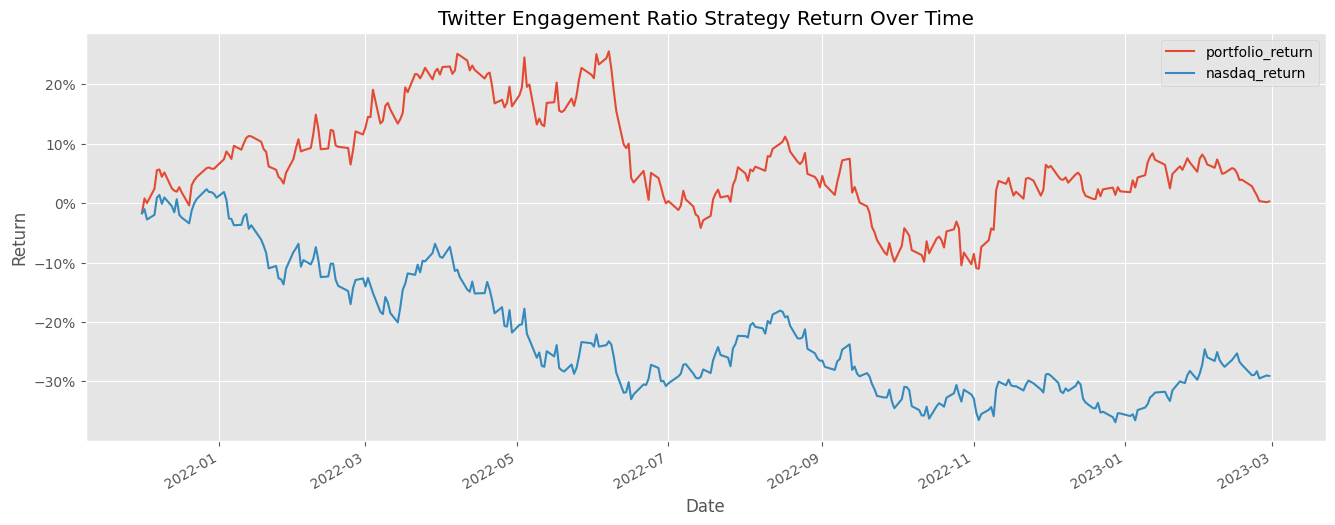

In [156]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()